# Imports and Preparing the data of behavior.tsv and news.tsv #

In [1]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path

# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Create a dictionary mapping 'news_id' to 'title'
news_title_dict = dict(zip(news['news_id'], news['title']))
articles_all = list(news['news_id'])

# Split 'history' into lists of baskets based on ids
# Get rid of NaNs
behaviors['history'] = behaviors['history'].fillna('')
# Group by user and get rid of duplicates in the history
user_histories = []
for user_id, user_data in behaviors.groupby('user_id'):
    one_history_string = " ".join(user_data['history'])
    splitted_without_duplicates = set(one_history_string.split())
    articles_list_per_user = list(splitted_without_duplicates)
    user_histories.append(articles_list_per_user)


# A-Priori Algorithm

In [2]:
# Pass 1
# Store count of each individual item
articles_count = {}

for history in user_histories:
    for article in history:
        if article in articles_count:
            articles_count[article] += 1
        else:
            articles_count[article] = 1

# Find frequent items
frequent_articles_apriori = {}

threshold = 500 #50.000 histories -> 1% ist 500

for article, count in articles_count.items():
    if count >= threshold:
        frequent_articles_apriori[article] = count

# Before Pass 2
# Create new array
frequent_singleton_table_apriori = {}
map_value = 1

for article in articles_all:
    if article in frequent_articles_apriori:
        frequent_singleton_table_apriori[article] = map_value
        map_value += 1
    else:
        frequent_singleton_table_apriori[article] = 0
        
# Pass 2
# Store pairs of items (articles) that are both frequent (in frequent_articles)

pairs_of_frequent_articles_apriori = {}

for history in user_histories:
    frequent_items_apriori = []
    for article in history:
        if article in frequent_singleton_table_apriori and frequent_singleton_table_apriori[article] > 0:
            frequent_items_apriori.append(article)

    len_freq_items = len(frequent_items_apriori)
    for i in range(len_freq_items):
        for j in range(i + 1, len_freq_items):
            article1, article2 = sorted((frequent_items_apriori[i], frequent_items_apriori[j]))
            pair = (article1, article2)

            if pair in pairs_of_frequent_articles_apriori:
                pairs_of_frequent_articles_apriori[pair] += 1
            else:
                pairs_of_frequent_articles_apriori[pair] = 1

min_support = 500
frequent_pairs_apriori = {}
for pair, count in pairs_of_frequent_articles_apriori.items():
    if count >= min_support:
        frequent_pairs_apriori[pair] = count
        
        
pairs_list_apriori = list(frequent_pairs_apriori.items())
sorted_pairs_apriori = sorted(pairs_list_apriori, key=lambda x: x[1], reverse=True)
top_10_apriori = sorted_pairs_apriori[:10]   
        
for pair, count in top_10_apriori:
    article1_id, article2_id = pair

    title1 = news.loc[news['news_id'] == article1_id, 'title'].values[0]
    title2 = news.loc[news['news_id'] == article2_id, 'title'].values[0]
    
    
# 3 set
triplets_of_frequent_articles = {}
frequent_triplets = {}

for history in user_histories:
    frequent_items_apriori = []
    for article in history:
        if frequent_singleton_table_apriori.get(article, 0) > 0:
            frequent_items_apriori.append(article)

    len_freq_items = len(frequent_items_apriori)
    for i in range(len_freq_items):
        for j in range(i + 1, len_freq_items):
            for k in range(j + 1, len_freq_items):
                article1, article2, article3 = sorted((frequent_items_apriori[i], frequent_items_apriori[j], frequent_items_apriori[k]))
                triplet = (article1, article2, article3)

                if article1 in frequent_singleton_table_apriori and article2 in frequent_singleton_table_apriori and article3 in frequent_singleton_table_apriori:
                    if triplet in triplets_of_frequent_articles:
                        triplets_of_frequent_articles[triplet] += 1
                    else:
                        triplets_of_frequent_articles[triplet] = 1

min_support = 150
for triplet, count in triplets_of_frequent_articles.items():
    if count >= min_support:
        frequent_triplets[triplet] = count

# PC-Y Algorithm

In [ ]:
# Pass 1 of the PC-Y algorithm: Count individual items and hash pairs
# Define parameters
min_support = 500
hash_table_size = 500000  # Size of the hash table

# Initialize counters
item_count = defaultdict(int)
hash_table = [0] * hash_table_size

# Count individual items and hash pairs, skipping self-pairs
for history in user_histories:
    for article in history:
        item_count[article] += 1

    # Generate item pairs using combinations and skip self-pairs
    for pair in combinations(history, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        hash_table[hash_index] += 1

# Create a bitmap based on the minimum support threshold
bitmap = [1 if count >= min_support else 0 for count in hash_table]

# Filter out infrequent items
frequent_articles_pcy = {article for article, count in item_count.items() if count >= min_support}
print(f"Number of frequent items: {len(frequent_articles_pcy)}")

#Pass 2
candidate_pairs = defaultdict(int)

for history in user_histories:
    # Filter to include only frequent items
    filtered_basket = [article for article in history if article in frequent_articles_pcy]

    for pair in combinations(filtered_basket, 2):
        if pair[0] != pair[1] and pair[0] in frequent_articles_pcy and pair[1] in frequent_articles_pcy:
            article1, article2 = sorted((pair[0], pair[1])) 
            hash_index = (hash(article1) + hash(article2)) % hash_table_size
            if bitmap[hash_index]:
                candidate_pairs[(article1, article2)] += 1

#identify frequent pairs
frequent_pairs_pcy = {pair: count for pair, count in candidate_pairs.items() if count >= min_support}
print(f"Number of frequent pairs: {len(frequent_pairs_pcy)}")

Number of frequent items: 267
Number of frequent pairs: 11


# Top-10 list of both algos

In [4]:
# Extract top 10 pairs from both algorithms
pairs_list_apriori = list(frequent_pairs_apriori.items())
sorted_pairs_apriori = sorted(pairs_list_apriori, key=lambda x: x[1], reverse=True)
top_10_apriori = sorted_pairs_apriori[:10]

pairs_list_pcy = list(frequent_pairs_pcy.items())
sorted_pairs_pcy = sorted(pairs_list_pcy, key=lambda x: x[1], reverse=True)
top_10_pcy = sorted_pairs_pcy[:10]

print("Top 10 Pairs - A-Priori:")
for pair, count in top_10_apriori:
    print(pair, count)
# Extract top 10 pairs from both algorithms
print("\nTop 10 Pairs - PCY:")
for pair, count in top_10_pcy:
    print(pair, count)

Top 10 Pairs - A-Priori:
('N306', 'N42620') 678
('N306', 'N43142') 655
('N306', 'N871') 646
('N306', 'N31801') 645
('N306', 'N45794') 609
('N306', 'N55189') 591
('N16715', 'N31801') 550
('N29177', 'N306') 546
('N45794', 'N46392') 544
('N306', 'N46392') 527

Top 10 Pairs - PCY:
('N306', 'N42620') 678
('N306', 'N43142') 655
('N306', 'N871') 646
('N306', 'N31801') 645
('N306', 'N45794') 609
('N306', 'N55189') 591
('N16715', 'N31801') 550
('N29177', 'N306') 546
('N45794', 'N46392') 544
('N306', 'N46392') 527


# Visualisation of Top-10

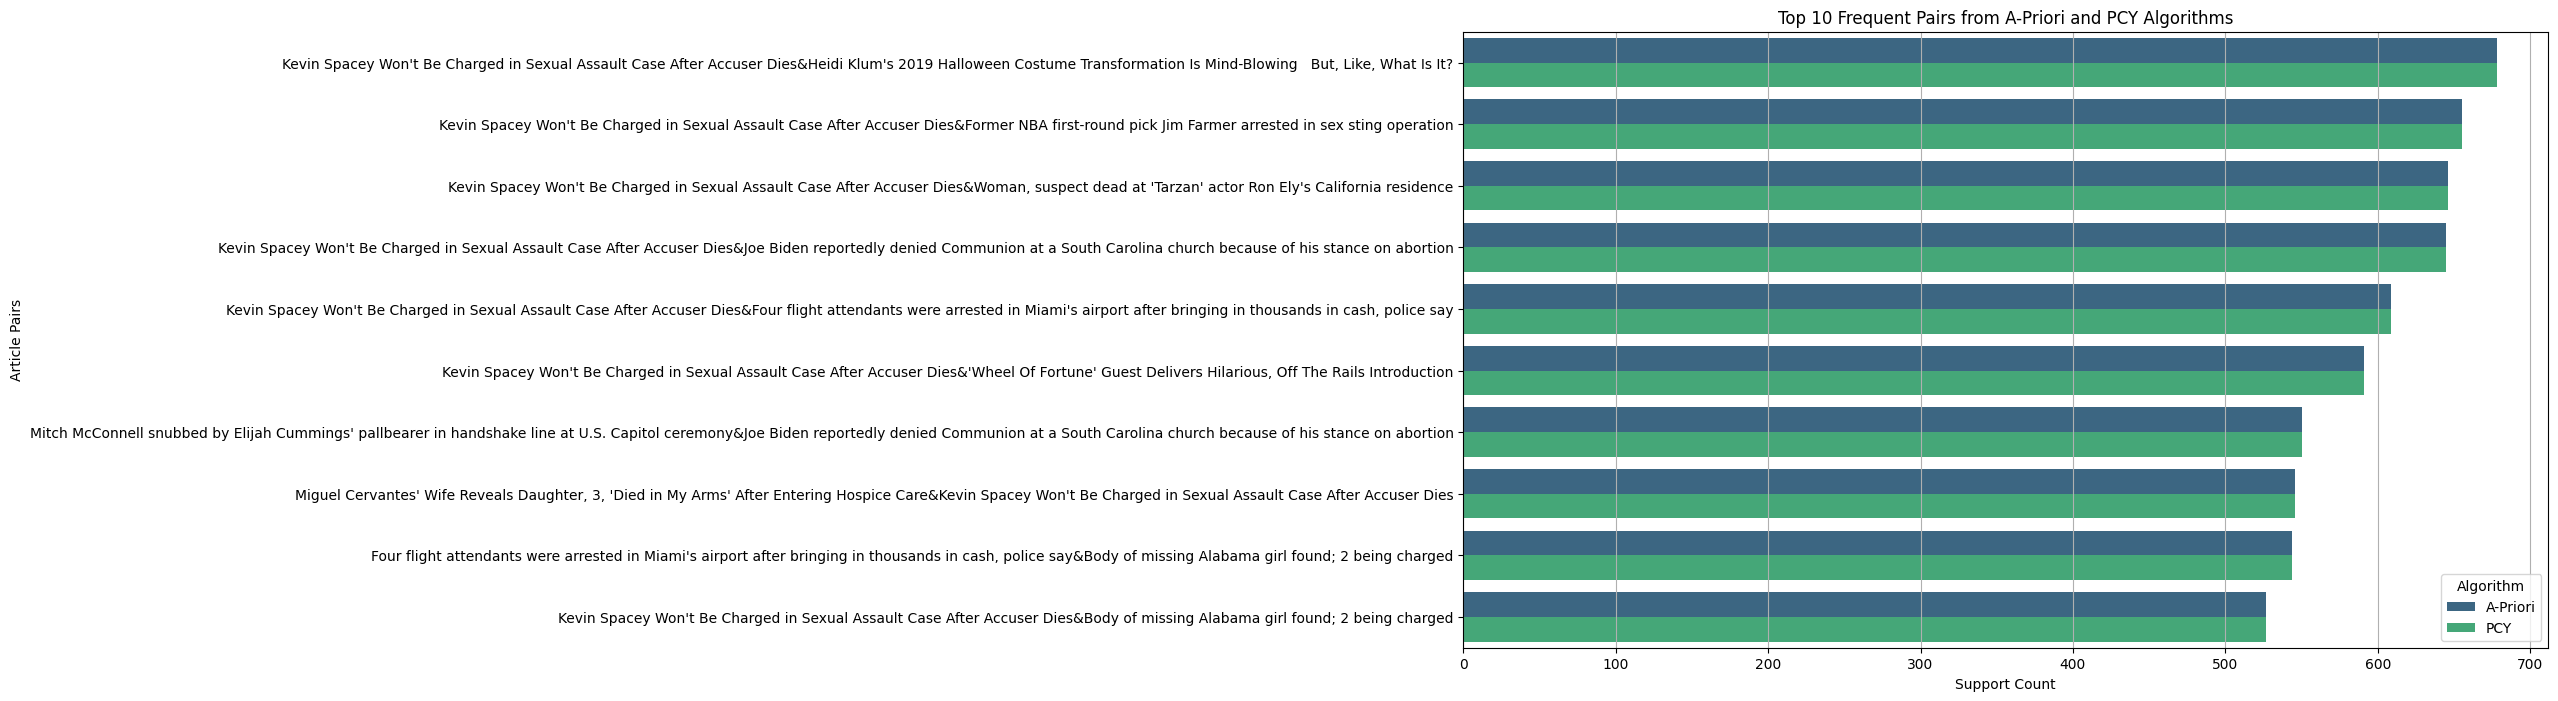

In [5]:
# Prepare data for plotting
apriori_pairs = []
apriori_counts = []
for pair, count in top_10_apriori:
    title = str(news_title_dict[pair[0]]) + "&" + str(news_title_dict[pair[1]])
    apriori_pairs.append(title)
    apriori_counts.append(count)

pcy_pairs = []
pcy_counts = []
for pair, count in top_10_pcy:
    title = str(news_title_dict[pair[0]]) + "&" + str(news_title_dict[pair[1]])
    pcy_pairs.append(title)
    pcy_counts.append(count)

# Df for easier vizualisation
plot_data = pd.DataFrame({
    'Pair': apriori_pairs + pcy_pairs,
    'Count': apriori_counts + pcy_counts,
    'Algorithm': ['A-Priori'] * 10 + ['PCY'] * 10})

plt.figure(figsize=(14, 8))
sns.barplot(data=plot_data, x='Count', y='Pair', hue='Algorithm', palette='viridis')

plt.title('Top 10 Frequent Pairs from A-Priori and PCY Algorithms')
plt.xlabel('Support Count')
plt.ylabel('Article Pairs')
plt.legend(title='Algorithm')
plt.grid(axis='x')
plt.show()


# Different Top 20 for A-Priori and PC-Y

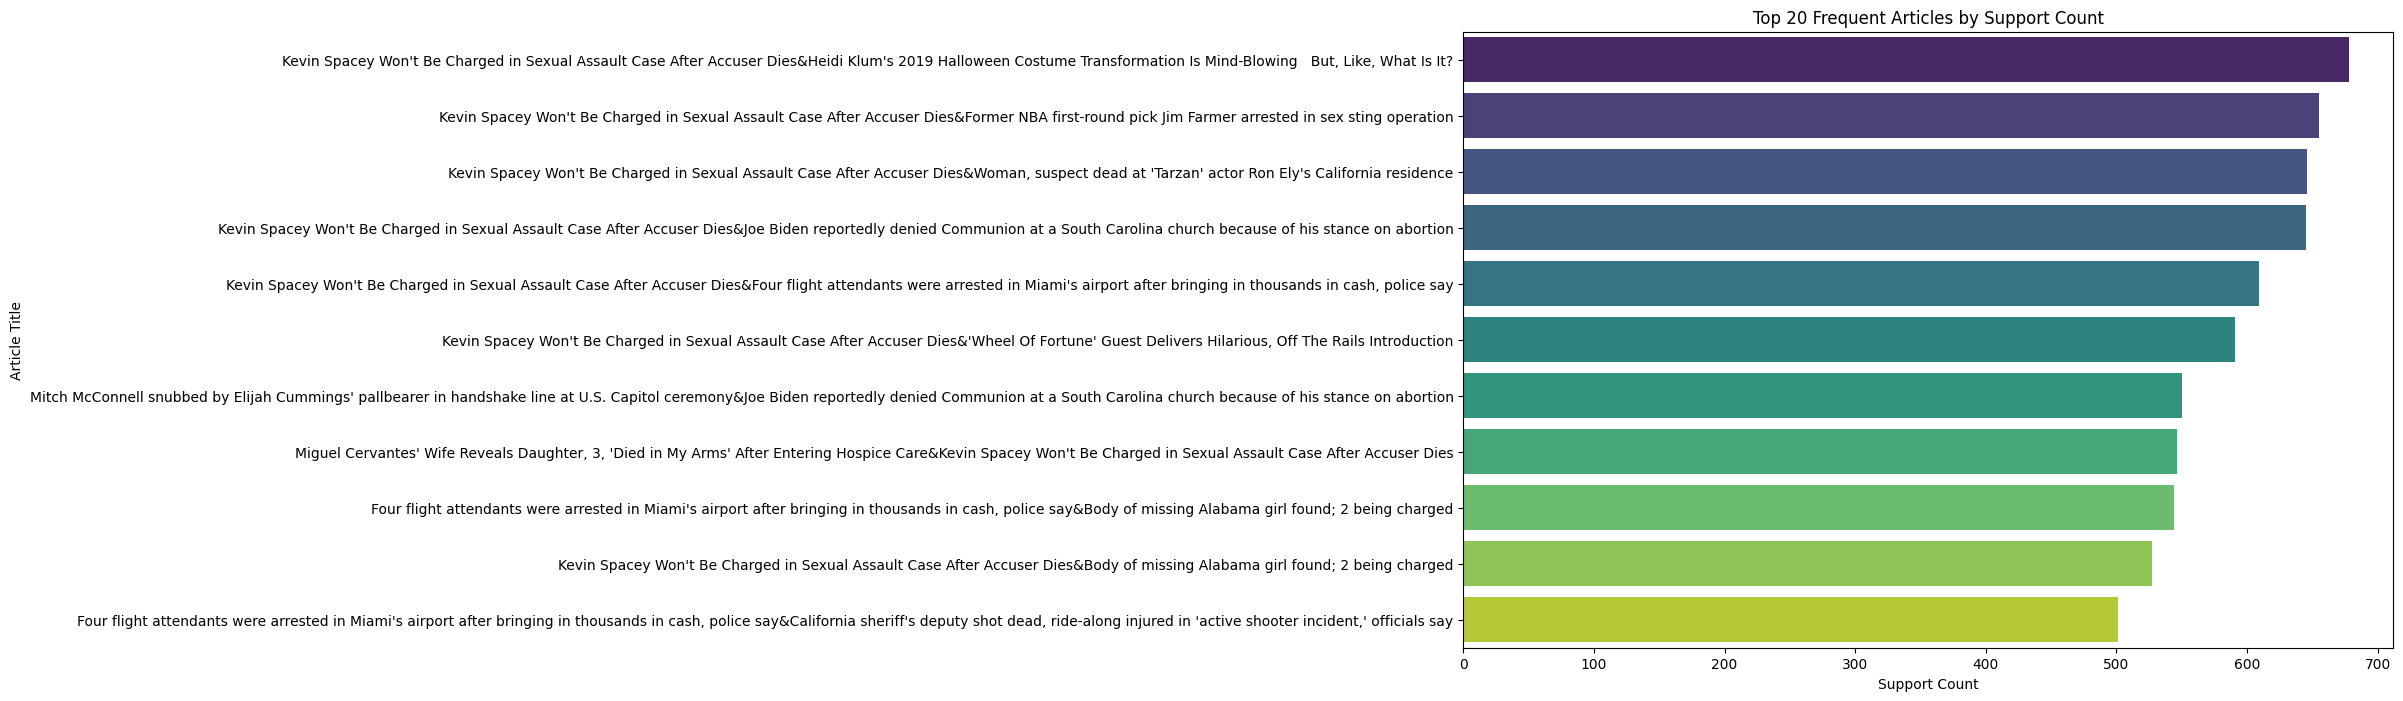

In [6]:
pairs_list_apriori = list(frequent_pairs_pcy.items())
sorted_pairs_apriori = sorted(pairs_list_apriori, key=lambda x: x[1], reverse=True)
top_10_apriori = sorted_pairs_apriori[:20]

pairs_list_pcy = list(frequent_pairs_pcy.items())
sorted_pairs_pcy = sorted(pairs_list_pcy, key=lambda x: x[1], reverse=True)
top_10_pcy = sorted_pairs_pcy[:20]

if top_10_apriori == top_10_pcy:

    apriori_pairs = []
    apriori_counts = []
    for pair, count in top_10_apriori:
        title = str(news_title_dict[pair[0]]) + "&" + str(news_title_dict[pair[1]])
        apriori_pairs.append(title)
        apriori_counts.append(count)

    plot_data = pd.DataFrame({
        'Title': apriori_pairs,
        'Count': apriori_counts})

    plt.figure(figsize=(12, 8))
    sns.barplot(data=plot_data, x='Count', y='Title', hue='Title', dodge=False, legend=False, palette='viridis')

    plt.title("Top 20 Frequent Articles by Support Count")
    plt.xlabel("Support Count")
    plt.ylabel("Article Title")
    plt.show()

else:
    "Different Top 20 for A-priori and PC-Y"

# Data summary of both algos

In [7]:
all_data_apriori = {
    "All_articles": len(articles_all),
    "In_histories": len(articles_count),
    "Frequent_articles_apriori": len(frequent_articles_apriori),
    "Frequent_pairs_apriori": len(frequent_pairs_apriori),
    "Frequent_triplets_apriori": len(frequent_triplets)
    #"Frequent_quadruplets_apriori": len(frequent_quadruplets)
}
all_data_apriori

{'All_articles': 51282,
 'In_histories': 33195,
 'Frequent_articles_apriori': 267,
 'Frequent_pairs_apriori': 11,
 'Frequent_triplets_apriori': 2}

In [9]:

all_data_pcy = {
    "All_articles": len(articles_all),
    "In_histories": len(articles_count),
    "Frequent_articles_pcy": len(frequent_articles_pcy),
    "Frequent_pairs_pcy": len(frequent_pairs_pcy)
}
all_data_pcy

{'All_articles': 51282,
 'In_histories': 33195,
 'Frequent_articles_pcy': 267,
 'Frequent_pairs_pcy': 11}

# Count Graph for A-Priori

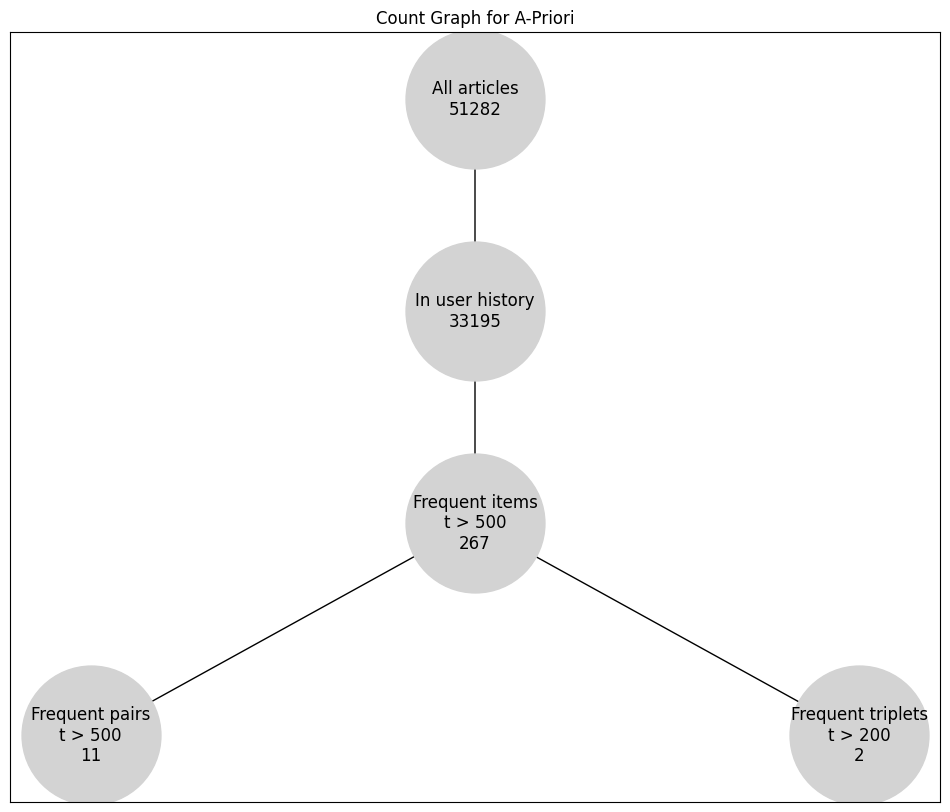

In [ ]:
A = "All articles\n" + str(len(articles_all))
B = "In user history\n" + str(len(articles_count))
C = "Frequent items\nt > 500\n" + str(len(frequent_articles_apriori))
D = "Frequent pairs\nt > 500\n" + str(len(frequent_pairs_apriori))
E = "Frequent triplets\nt > 200\n" + str(len(frequent_triplets))
# F = "Frequent quadruplets\nt > ?\" + str(len(frequent_quadruplets))

G = nx.DiGraph()
G.add_edges_from(
    [(A, B), 
     (B, C),
     (C, D),
     (C, E)])

G.nodes[A]["subset"] = 0
G.nodes[B]["subset"] = 1
G.nodes[C]["subset"] = 2
G.nodes[D]["subset"] = 3
G.nodes[E]["subset"] = 3

pos = nx.multipartite_layout(G, subset_key="subset")

pos = {node: (y, -x) for node, (x, y) in pos.items()}

plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_size=10000, node_color="lightgray")
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

plt.title("Count Graph for A-Priori")
plt.show()

# Count Graph for PC-Y

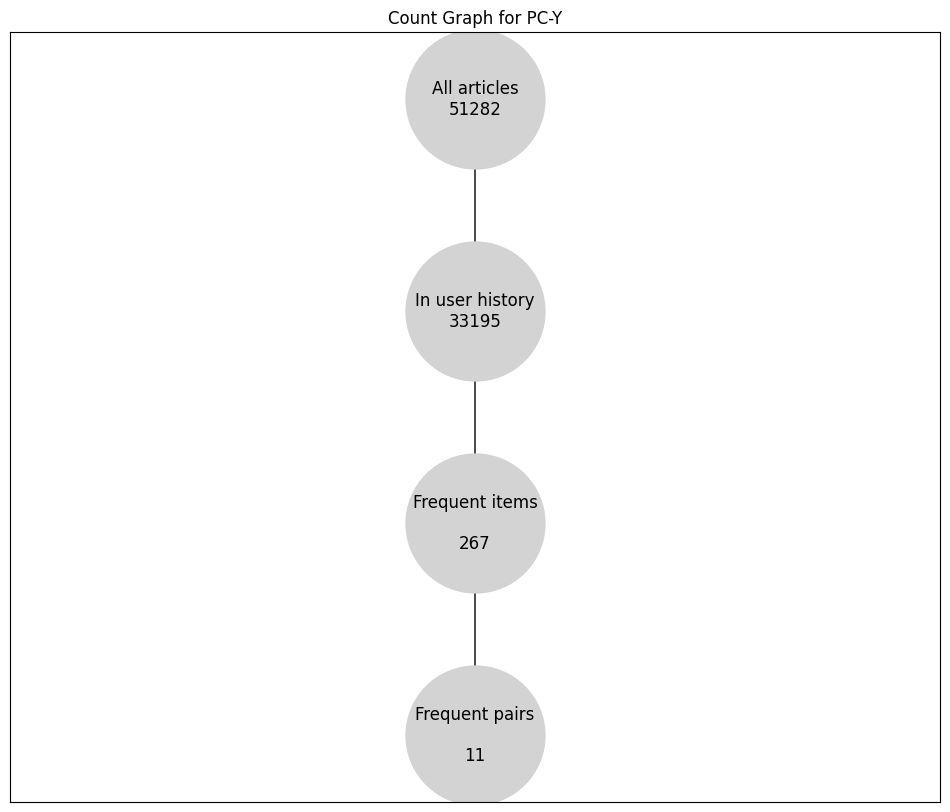

In [ ]:
A = "All articles\n" + str(len(articles_all))
B = "In user history\n" + str(len(articles_count))
C = "Frequent items\n\n" + str(len(frequent_articles_pcy))
D = "Frequent pairs\n\n" + str(len(frequent_pairs_pcy))

G = nx.DiGraph()
G.add_edges_from(
    [(A, B), 
     (B, C),
     (C, D)])

G.nodes[A]["subset"] = 0
G.nodes[B]["subset"] = 1
G.nodes[C]["subset"] = 2
G.nodes[D]["subset"] = 3

pos = nx.multipartite_layout(G, subset_key="subset")

pos = {node: (y, -x) for node, (x, y) in pos.items()}

plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_size=10000, node_color="lightgray")
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

plt.title("Count Graph for PC-Y")
plt.show()